In [13]:
!pip install jellyfish

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 7.6 MB/s eta 0:00:00


In [14]:
# Cell 1: Import all required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import jellyfish

In [6]:
# Cell 2: Load the data
gen_pars = pickle.load(open("gen_pairs.pkl", "rb"))

In [20]:
# Cell 3: Define transform_features function
def transform_features(data, cv=None):
    import jellyfish
    import zlib
    lefts = []
    rights = []
    labels = []
    X_ed = []

    for t1 in data:
        if len(t1) == 3:
            n1, n2, label = t1
        else:
            n1, n2, label, *rest = t1
        lefts.append(n1)
        rights.append(n2)
        X_ed.append([
            #jellyfish.jaro_distance(n1, n2),
            # Use jellyfish.jaro_winkler instead of jellyfish.jaro_distance
            jellyfish.jaro_similarity(n1, n2),
            jellyfish.levenshtein_distance(n1, n2) / float(max(len(n1), len(n2))),
            len(zlib.compress((n1 + n2).encode("utf-8"))) / float(len(zlib.compress((n1).encode("utf-8"))) +
                               len(zlib.compress(n2.encode("utf-8"))))
        ])
        labels.append(label)

    X = cv.transform(lefts) - cv.transform(rights)
    import scipy.sparse
    X = scipy.sparse.hstack([X, X_ed]).tocsc()
    return X, np.array(labels)

In [8]:
# Cell 4: Define Random Forest classifier with confusion matrix
def random_forest_classification(X_train, y_train, X_test, y_test):
    print("\n=== Random Forest Classification ===")
    rf = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, n_jobs=16)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    accuracy = rf.score(X_test, y_test)
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy

In [9]:
# Cell 5: Define SVM classifier with confusion matrix
def svm_classification(X_train, y_train, X_test, y_test):
    print("\n=== SVM Classification ===")
    svm = LinearSVC(random_state=0, C=1)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    accuracy = svm.score(X_test, y_test)
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title('SVM Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy

In [10]:
# Cell 6: Main classification function
def do_classification(X_train_raw, X_dev_raw, y_train, y_dev, gen_pars):
    scores = {}
    data_train = [gen_pars[tk] for tk in X_train_raw]
    data_dev = [gen_pars[tk] for tk in X_dev_raw]

    # Prepare features
    cv = CountVectorizer(analyzer="char_wb", preprocessor=lambda x: x)
    data_train_cv = [tj for tk in data_train for tj in tk[:2]]
    cv.fit(data_train_cv)
    X_train, y_train_l1 = transform_features(data_train, cv=cv)
    X_test, y_test = transform_features(data_dev, cv=cv)

    print("\n=== Whole Features ===")
    scores['rf_whole'] = random_forest_classification(X_train, y_train, X_test, y_test)
    scores['svm_whole'] = svm_classification(X_train, y_train, X_test, y_test)

    # TF-IDF features
    print("\n=== TF-IDF Features ===")
    data_train_s = [tk[0].split("_")[1] + " " + tk[1].split("_")[1] for tk in data_train]
    data_dev_s = [tk[0].split("_")[1] + " " + tk[1].split("_")[1] for tk in data_dev]

    tfidf_vec = TfidfVectorizer(analyzer="char_wb", ngram_range=(1, 3))
    x_train_tf = tfidf_vec.fit_transform(data_train_s)
    x_dev_tf = tfidf_vec.transform(data_dev_s)

    scores['svm_tfidf'] = svm_classification(x_train_tf, y_train, x_dev_tf, y_test)

    return scores

=== FULL DATASET ===

=== Whole Features ===

=== Random Forest Classification ===
Accuracy: 0.9264


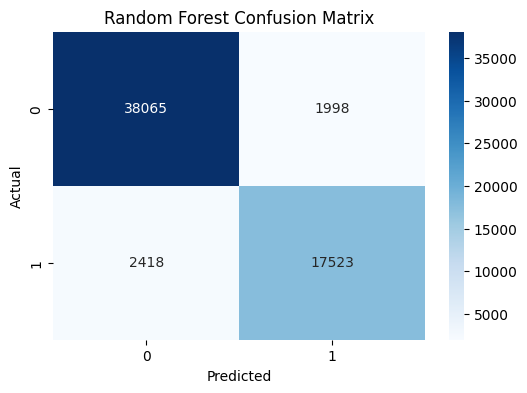


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     40063
           1       0.90      0.88      0.89     19941

    accuracy                           0.93     60004
   macro avg       0.92      0.91      0.92     60004
weighted avg       0.93      0.93      0.93     60004


=== SVM Classification ===
Accuracy: 0.7135


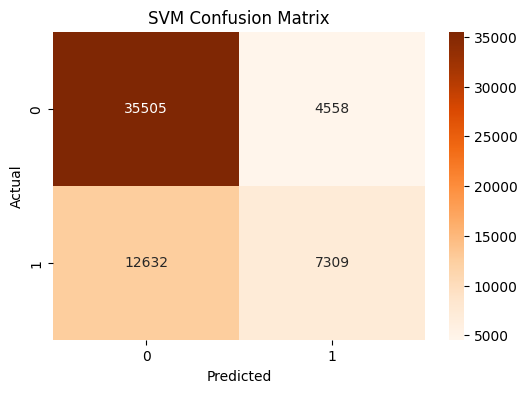


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81     40063
           1       0.62      0.37      0.46     19941

    accuracy                           0.71     60004
   macro avg       0.68      0.63      0.63     60004
weighted avg       0.70      0.71      0.69     60004


=== TF-IDF Features ===

=== SVM Classification ===
Accuracy: 0.6845


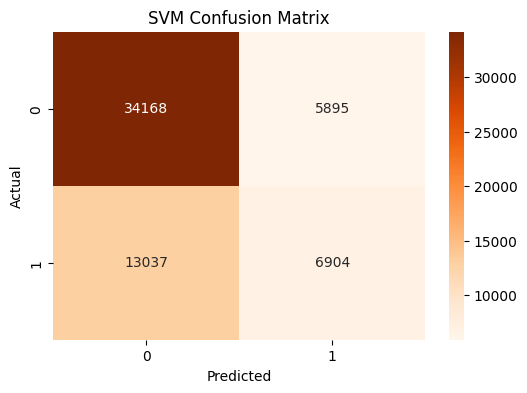


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78     40063
           1       0.54      0.35      0.42     19941

    accuracy                           0.68     60004
   macro avg       0.63      0.60      0.60     60004
weighted avg       0.66      0.68      0.66     60004



In [21]:
# Cell 7: Main execution
print("=== FULL DATASET ===")
idxs = range(len(gen_pars))
X_train_raw_t, X_dev_raw_t, y_train_t, y_dev_t = train_test_split(
    idxs, [tk[2] for tk in gen_pars], test_size=0.2, random_state=42)


In [ ]:
results = do_classification(X_train_raw_t, X_dev_raw_t, y_train_t, y_dev_t, gen_pars)

In [ ]:
# Cell 8: Cross-validation for full dataset
print("\n=== CROSS VALIDATION (FULL DATASET) ===")
results_cv_tab4 = {'rf_whole': [], 'svm_whole': [], 'svm_tfidf': []}
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(idxs):
    X_train_raw_t = train_index
    X_dev_raw_t = test_index
    y_train_t = [gen_pars[tk][2] for tk in train_index]
    y_dev_t = [gen_pars[tk][2] for tk in test_index]
    fold_results = do_classification(X_train_raw_t, X_dev_raw_t, y_train_t, y_dev_t, gen_pars)
    for key in results_cv_tab4:
        results_cv_tab4[key].append(fold_results[key])

print("\nCross-Validation Results (Full Dataset):")
for model, scores in results_cv_tab4.items():
    print(f"{model}: Mean Accuracy = {np.mean(scores):.4f} (±{np.std(scores):.4f})")


=== CROSS VALIDATION (FULL DATASET) ===

=== Whole Features ===

=== Random Forest Classification ===


In [ ]:
# Cell 9: Simple dataset (first 200k samples)
print("\n=== SIMPLE DATASET (FIRST 200K SAMPLES) ===")
idxs = range(200000)
X_train_raw_SIMPLE, X_dev_raw_SIMPLE, y_train_SIMPLE, y_dev_SIMPLE = train_test_split(
    idxs, [tk[2] for tk in gen_pars[:200000]], test_size=0.2, random_state=42)
simple_results = do_classification(X_train_raw_SIMPLE, X_dev_raw_SIMPLE, y_train_SIMPLE, y_dev_SIMPLE, gen_pars)

In [ ]:
# Cell 10: Cross-validation for simple dataset
print("\n=== CROSS VALIDATION (SIMPLE DATASET) ===")
results_cv_tab3 = {'rf_whole': [], 'svm_whole': [], 'svm_tfidf': []}
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(idxs):
    X_train_raw_t = train_index
    X_dev_raw_t = test_index
    y_train_t = [gen_pars[tk][2] for tk in train_index]
    y_dev_t = [gen_pars[tk][2] for tk in test_index]
    fold_results = do_classification(X_train_raw_t, X_dev_raw_t, y_train_t, y_dev_t, gen_pars)
    for key in results_cv_tab3:
        results_cv_tab3[key].append(fold_results[key])

print("\nCross-Validation Results (Simple Dataset):")
for model, scores in results_cv_tab3.items():
    print(f"{model}: Mean Accuracy = {np.mean(scores):.4f} (±{np.std(scores):.4f})")